In [132]:
!pip3 install torch
!pip3 install VaderSentiment
!pip3 install transformers
!pip3 install sentence-transformers
!pip3 install umap-learn
!pip3 install hdbscan

In [35]:
#import necessary libraries

import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,CSVLogger

import torch
import transformers as ppb # pytorch transformers

from sentence_transformers import SentenceTransformer
import umap
import hdbscan

In [3]:
gc.set_threshold(20,5,5)
gc.collect()

1118

In [4]:
product_reviews_ratings=pd.read_csv('/content/drive/My Drive/amazon_reviews_project/pre_processed_data.csv')
product_reviews_ratings.head(2)

,asin,overall,verified,reviewText,reviewTime
0,0007444117,1,False,I was a huge fan when the Divergent series sta...,2016-09-03
1,0007177437,4,True,Excellent read.,2015-09-16


In [5]:
product_reviews_ratings['asin'].value_counts()

038568231X    8736
0312577222    7092
1683247353    4745
0553418025    4726
1503943372    4522
              ... 
0809452502       1
1259547566       1
0380728540       1
1496178041       1
B000L86GMC       1
Name: asin, Length: 975727, dtype: int64

In [6]:
#Let's create a list of 5 most reviewed books from this list
product_list=product_reviews_ratings['asin'].value_counts().index[:5]
product_list

Index(['038568231X', '0312577222', '1683247353', '0553418025', '1503943372'], dtype='object')

In [7]:
#Let's start testing with the most reviewed item: '038568231X'
reviews_1=product_reviews_ratings[product_reviews_ratings['asin']=='038568231X']
reviews_1.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
selected_reviews=reviews_1[(reviews_1['overall']==3)|(reviews_1['overall']==4)]

In [62]:
#Creating a dataframe with only the text of selected reviews
data=selected_reviews[['reviewText']]

#reset index
data.reset_index(inplace=True)

#And let's drop all nulls
data.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
data.drop('index',axis=1,inplace=True)
data

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,reviewText
0,Pros: good pacing; not boring; easy to read in...
1,"Slow going at first, almost to the point of bo..."
2,"Everyone called this book the new ""Gone Girl""...."
3,This book was GREAT! I would've given it 5 sta...
4,"An easy read with a watchable, fraught heroine..."
...,...
3513,With how much buzz this book got I expected mo...
3514,Great reading looking forward to the movie.
3515,I always enjoy a story where the heroine is se...
3516,A talk show host mentioned this title on a loc...


In [64]:
#sentence embeddings
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data['reviewText'], show_progress_bar=True)

In [111]:
#reduce dimensionality to 6, keeping neighbors at 50 
umap_embeddings = umap.UMAP(n_neighbors=100,n_components=6,metric='cosine').fit_transform(embeddings)

In [112]:
#clustering using HDBSCAN
clusters=hdbscan.HDBSCAN(min_cluster_size=16,metric='euclidean',cluster_selection_method='eom').fit(umap_embeddings)

In [113]:
#Let's explore what clusters and the docs in each cluster

In [134]:
labels=np.unique(clusters.labels_)
labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [115]:
#we can use the UMAP method we have used previously to create embedding in 2d and visualize the findings.
umap_embeddings_2D=umap.UMAP(n_neighbors=25,n_components=2,metric='cosine').fit_transform(embeddings)
df_umap_embeddings_2D=pd.DataFrame(umap_embeddings_2D,columns=['x','y'])
df_umap_embeddings_2D['label']=clusters.labels_


In [141]:
df_umap_embeddings_2D['label'].value_counts(normalize=True)

-1     0.538658
 11    0.214042
 6     0.040932
 9     0.037806
 13    0.033826
 5     0.025867
 0     0.021603
 10    0.020466
 7     0.015634
 4     0.013644
 12    0.009665
 3     0.008528
 8     0.006822
 1     0.006254
 2     0.006254
Name: label, dtype: float64

It appears we can capture over 88% of the reviews by considering the top 6 labels (including unclustered).

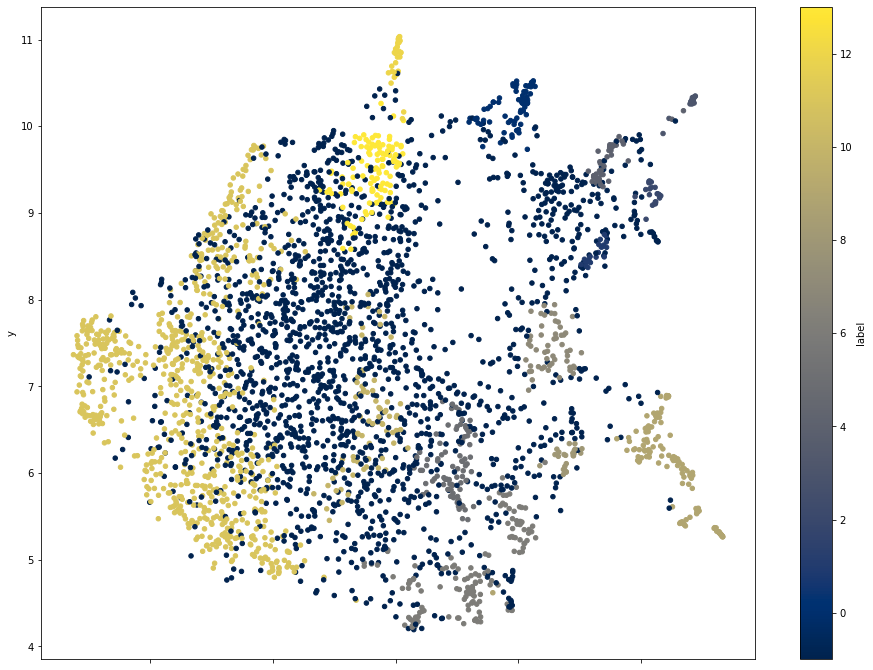

In [131]:
#Now let's plot df_umap_embeddings_2D

df_umap_embeddings_2D.plot(x='x',y='y',kind='scatter',c='label',cmap='cividis',figsize=(16,12))

In [151]:
#Let's create a column with labels in the original dataframe
data['label']=df_umap_embeddings_2D['label']
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,label
0,Pros: good pacing; not boring; easy to read in...,11
1,"Slow going at first, almost to the point of bo...",10
2,"Everyone called this book the new ""Gone Girl""....",-1
3,This book was GREAT! I would've given it 5 sta...,11
4,"An easy read with a watchable, fraught heroine...",-1
...,...,...
3513,With how much buzz this book got I expected mo...,11
3514,Great reading looking forward to the movie.,-1
3515,I always enjoy a story where the heroine is se...,-1
3516,A talk show host mentioned this title on a loc...,-1


clusters larger than 2% of total number of reviews accounts from ~93% of the sample. So let's create a map with only those clusters.

In [142]:
selected_clusters=[i for i in range(-1,14) if df_umap_embeddings_2D['label'].value_counts(normalize=True)[i]>0.02]
selected_clusters

[-1, 0, 5, 6, 9, 10, 11, 13]

Let's create a map with just these

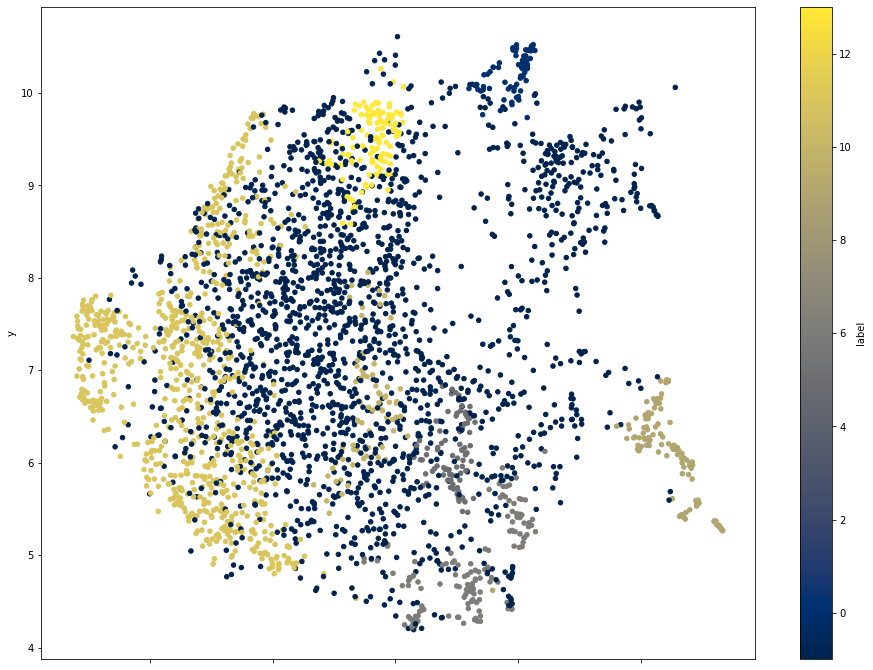

In [145]:
df_umap_embeddings_2D_selected_clusters=df_umap_embeddings_2D[df_umap_embeddings_2D['label'].isin(selected_clusters)]
df_umap_embeddings_2D_selected_clusters.plot(x='x',y='y',kind='scatter',c='label',cmap='cividis',figsize=(16,12))

In [156]:
#We can perform the same operation on original dataframe to extract the corresponding reviews.

data_selected_clusters=data[data['label'].isin(selected_clusters)].copy(deep=True)
data_selected_clusters

,reviewText,label
0,Pros: good pacing; not boring; easy to read in...,11
1,"Slow going at first, almost to the point of bo...",10
2,"Everyone called this book the new ""Gone Girl""....",-1
3,This book was GREAT! I would've given it 5 sta...,11
4,"An easy read with a watchable, fraught heroine...",-1
...,...,...
3513,With how much buzz this book got I expected mo...,11
3514,Great reading looking forward to the movie.,-1
3515,I always enjoy a story where the heroine is se...,-1
3516,A talk show host mentioned this title on a loc...,-1


We'll identify the prominent themes in each of these clusters using TF-IDF. Since we'll be performing this operation several times, this is a good place to write an function that would do it for us.

In [191]:
def create_doc(input_dataframe,clusters_to_select):
  docs=[]
  for label in clusters_to_select:
    doc=input_dataframe[input_dataframe['label']==label]
    docs.append(doc)
  return docs

In [192]:
docs=create_doc(data_selected_clusters,selected_clusters)
print(docs)

[                                             reviewText  label
2     Everyone called this book the new "Gone Girl"....     -1
4     An easy read with a watchable, fraught heroine...     -1
8     Good reading, story moves along well.  Good st...     -1
9     This book makes you feel uncomfortable as you'...     -1
10                   Interesting character interactions     -1
...                                                 ...    ...
3512                          A perverbial page-turner!     -1
3514        Great reading looking forward to the movie.     -1
3515  I always enjoy a story where the heroine is se...     -1
3516  A talk show host mentioned this title on a loc...     -1
3517  I really enjoyed the book. It had some interes...     -1

[1895 rows x 2 columns],                                   reviewText  label
59                          Intriguing novel      0
67                          I love this book      0
149                               Great book      0
164      

In [213]:
def docs_TFIDF_vectorizer(docs):
  from sklearn.feature_extraction.text import TfidfVectorizer

  stop_words = text.ENGLISH_STOP_WORDS.union(['00', '10', '100', '12', '15', '16', '20', '200', '24', '25',\
       '2nd', '30', '40', '45', '50', '60', '75', '80', '90','!',"''","'m","'s",',','.','...','He','I','It','My','Of','``',\
        '!',"''","'m","'re","'s",',','-','.','...','9','An','Ca','Do','I','It','S.','``','!',"''","'s",'(',')',',','-','.',\
        'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y','&',"'ll",'-D','5',':','?',\
        "'", '0', '1', '2', '3', '4', '6', '7', '8', 'A', 'C', 'D', 'H', 'M', 'O', 'S', '`','#',"'ve",'*','--','..','....','10/10','4/5',';',\
        'As','At','HE','IS','IT','If','In','MY','No','ON','On','PR','SO','So','St','To','US','We','/', 'E', 'N', 'P', 'R', 'T', 'U', 'W', 'Y',\
        '$','%',"'S","'d",'.....','1/2','1/3','105','12-lead','125','14','150','198','1\\23\\18','22','221','27','3-3.5','35','AM','Be','By',\
        'CK','DJ','De','Dr','HM','JE','K.','L','MB','Mr','Ms','R.','TO','W.','YA','B', 'J', 'K', '\\','@','Im','Me','Is'])
  
  #initialize TFIDF vectorizer
  vectorizer = TfidfVectorizer(stop_words=stop_words)

  #create an empty list
  tfidf_vectorized_docs=[]

  #loop over the docs
  for doc in docs:
    X=vectorizer.fit_transform(doc['reviewText'])
    tfidf_vectorized_docs.append((vectorizer.get_feature_names(),X))
  
  return tfidf_vectorized_docs

In [214]:
tfidf_data=docs_TFIDF_vectorizer(docs)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['18', '23', 'ca', 'ck', 'dj', 'dr', 'hm', 'im', 'je', 'lead', 'll', 'mb', 'mr', 'ms', 'pr', 'st', 've', 'ya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [218]:
tfidf_data

[(['100ish',
   '11',
   '178',
   '191',
   '1945',
   '1st',
   '2015',
   '2016',
   '70',
   '7th',
   '86',
   '99',
   'abit',
   'able',
   'aboard',
   'abrupt',
   'abruptly',
   'absolutely',
   'absorbed',
   'absorbing',
   'abuse',
   'abused',
   'abusive',
   'accents',
   'accepted',
   'accessible',
   'accidently',
   'accords',
   'accounts',
   'accurate',
   'achieve',
   'achieved',
   'achievement',
   'achingly',
   'achololic',
   'acquainted',
   'act',
   'acting',
   'action',
   'actions',
   'active',
   'activity',
   'actual',
   'actually',
   'ad',
   'adaptation',
   'adapted',
   'add',
   'added',
   'addicted',
   'addicting',
   'addiction',
   'addictive',
   'adds',
   'adele',
   'adequate',
   'admirable',
   'admire',
   'admired',
   'admit',
   'adultery',
   'advance',
   'advertising',
   'affair',
   'affairs',
   'africa',
   'afternoon',
   'agape',
   'agatha',
   'ages',
   'ago',
   'agree',
   'ahead',
   'air',
   'airplane',
   '

In [221]:
tfidf_data_complete_list=[pd.DataFrame(tfidf_data[i][1].todense(),columns=tfidf_data[i][0]) for i in range(len(tfidf_data))]

In [223]:
selected_clusters

[-1, 0, 5, 6, 9, 10, 11, 13]

The corresponding dataframes with tfidf data maybe called df_unclustered, df_0, df_5, df_6, df_9, df_10, df_11, df_13. We can assign names easily as follows:

In [224]:
[df_unclustered,df_0,df_5,df_6,df_9,df_10,df_11,df_13]=[pd.DataFrame(tfidf_data[i][1].todense(),columns=tfidf_data[i][0]) for i in range(len(tfidf_data))]

Let's take a look at couple example to check if this worked.

In [227]:
df_unclustered.head(2)

,100ish,11,178,191,1945,1st,2015,2016,70,7th,86,99,abit,able,aboard,abrupt,abruptly,absolutely,absorbed,absorbing,abuse,abused,abusive,accents,accepted,accessible,accidently,accords,accounts,accurate,achieve,achieved,achievement,achingly,achololic,acquainted,act,acting,action,actions,...,worked,working,workings,works,world,worried,worse,worst,worth,worthwhile,worthy,wouldn,wouldnt,wound,woven,wow,wowed,wrap,wrapped,wreck,write,writen,writer,writers,writes,writing,written,wrong,wrote,ws,wwii,xmas,yarn,year,years,yes,young,younger,zero,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
df_0.head(2)

,actually,adult,author,awesome,big,book,captivating,club,construct,decent,discussion,disturbing,dragged,end,ending,engaging,enjiyed,enjoy,enjoyable,enjoyed,enjoying,entertained,excellent,expectations,figured,flaws,forward,good,great,gripping,guessing,im,interesting,intrigued,intriguing,isn,just,keeps,kept,kind,language,little,looking,lots,love,loved,mark,met,mistery,nice,novel,places,pleasant,pretty,quality,read,reading,really,say,situations,smart,stars,surprises,surprising,suspenseful,thing,think,tough,twist,twists,ve,wanting,written
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.681888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.731456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.237891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.971292,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
df_5.head(2)

,able,bad,bang,began,beginning,betrays,better,bit,boo,book,boring,builds,burn,caused,chapter,chapters,character,climax,clues,confusing,couldn,cresendo,decent,decently,definitely,depressing,did,difficult,disappointing,downhill,dragged,drew,easier,easy,end,ended,ending,ends,engaging,enjoyable,...,read,reading,real,really,repetitive,returning,second,set,short,slow,slowly,sparkles,spots,start,started,starter,starts,stop,story,study,stupid,suspense,suspenseful,switching,tad,te,tedious,thought,ties,time,times,turned,turner,twists,unpredictable,unrealistic,way,worth,wound,written
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.259629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.47277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are finally ready to look at the most prominent words for each cluster.

In [233]:
df_unclustered.sum().nlargest(10)

book           115.326407
read           108.387578
good            96.542057
story           72.660651
great           56.581320
characters      52.965162
enjoyed         49.763950
end             47.356484
ending          45.007488
interesting     42.326692
dtype: float64

In [245]:
#List comprehension to create separate list for each cluster
n_prominent_words=[df.sum().nlargest(10).index for df in [df_unclustered,df_0,df_5,df_6,df_9,df_10,df_11,df_13]]

In [251]:
df_n_prominent_words=pd.DataFrame(n_prominent_words).T
df_n_prominent_words.columns=['df_unclustered','df_0','df_5','df_6','df_9','df_10','df_11','df_13']

In [252]:
df_n_prominent_words

,df_unclustered,df_0,df_5,df_6,df_9,df_10,df_11,df_13
0,book,book,slow,hard,good,book,book,book
1,read,good,good,good,ok,read,read,read
2,good,great,read,girl,predictable,good,story,enjoyed
3,story,enjoyed,little,gone,loved,hard,characters,good
4,great,read,start,little,okay,slow,good,recommend
5,characters,loved,bit,boring,interesting,took,girl,story
6,enjoyed,interesting,beginning,didn,entertaining,end,movie,kept
7,end,love,great,couldn,enjoyed,little,like,characters
8,ending,intriguing,starts,story,enjoyable,did,train,great
9,interesting,end,hard,like,great,couldn,character,reading


### These are quick impressions on the clusters based on just the words with high TF-IDF values. 

**df_unclustered:**  This is our largest group. They enjoyed the characters, the story and especially the ending. The book was interesting to them.   
**df_0:**  Found the book an enjoyable read with a very interesting story. Like most people in the unclustered group, they frequently mentioned the ending in their reviews.  
**df_5:**  This group thought the book was great. It's very likely that as they found the story to be slow to start.  
**df_6:**  Found the book boring, perhaps somewhat predictable.  
**df_9:**  Found the book predictable but enjoyed it somewhat.  
**df_10:**  Found the book good but slow and perhaps couldn't get to the end.  
**df_11:**  It's a little hard to predict from this list of words, except their reviews put a stronger emphasis on characters. It seems they enjoyed it.  
**df_13:**  Thought the book is great, with great characters and would recommend it to others.  